# Multi-Class Classification

## 1. Imports

In [7]:
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Any, Union

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud

from preprocess_functions import map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance, replace_text_components, \
    clean_text, lemmatize_text, remove_stopwords, tokenizer_transform

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = False
RETRAIN = False
RANDOM_STATE = 42
MODEL_LEVEL = 'general'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    'gaussian_nb': GaussianNB(),
    #'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

NameError: name 'LogisticRegression' is not defined

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
#BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
#ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
#MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
TWEETS_PKL = DATASET_DIR / 'sub_tweets_train.pkl'

GENERAL_PKL = MODELS_DIR / 'general.pkl'
#BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
#CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
#CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'
#LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
#PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'
#CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
#MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
#br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
#mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [14]:
import pickle

with open(TWEETS_PKL, 'rb') as f:
    tweets = pd.DataFrame(pickle.load(f), columns=[
        '_id', 'date',
        'id', 'relevant', 'text', 'tweet', 'type', 'watson',
        'annotation', 'urls', 'destination_url',
        'valid_certificate', 'watson_list', 'target'
    ])

tweets = tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,)))
tweets['text'] = [replace_text_components(t) for t in tweets['text']]
tweets['text'] = [clean_text(t) for t in tweets['text']]
tweets['text'] = [lemmatize_text(t) for t in tweets['text']]
tweets['text'] = [remove_stopwords(t) for t in tweets['text']]

print(f"Threat Tweets: {len(tweets)}")
tweets.head()

Threat Tweets: 12728


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,b'5b97708abb325e7a2e19a30a',2018-09-11 07:36:42+00:00,1039417434959163392,True,operator suffer downtime due ddos last month p...,{'created_at': 'Tue Sep 11 07:36:42 +0000 2018...,ddos,{'travel': {'tourist destinations': {'caribbea...,threat,[],NaN,NaN,"[travel, tourist destinations, caribbean, tech...",[computer security]
1,b'5b94d26bbb325e521c5af9b2',2018-09-09 07:57:30+00:00,1038697894583382016,True,cve201816663 issue discover contiking thro,{'created_at': 'Sun Sep 09 07:57:30 +0000 2018...,general,{'art and entertainment': {'shows and events':...,threat,"['https://ift.tt/2wXgFLZ', 'https://twitter.co...",https://ift.tt/2wXgFLZ,True,"[art and entertainment, shows and events, conf...",[other]
2,b'5b92d10fbb325e521c5ae48b',2018-09-07 19:27:11+00:00,1038146680389087232,True,ismartviewpro 15 savepath screenshots local bu...,{'created_at': 'Fri Sep 07 19:27:11 +0000 2018...,general,{'technology and computing': {'operating syste...,threat,['https://www.secnews24.com/2018/09/07/ismartv...,https://scrufa4.com,True,"[technology and computing, operating systems, ...","[software, operating systems]"
3,b'5b946854bb325e521c5af630',2018-09-09 00:24:51+00:00,1038583981871124480,True,get ddos suspend btw im shit fair play always ...,{'created_at': 'Sun Sep 09 00:24:51 +0000 2018...,ddos,{'style and fashion': {'clothing': {'pants': {...,threat,['https://twitter.com/i/web/status/10385839818...,https://twitter.com/i/web/status/1038583981871...,True,"[style and fashion, clothing, pants, technolog...",[computer security]
4,b'5b8882f5bb325e65fa7e7943',2018-08-30 23:51:16+00:00,1035314038111121408,True,skype empresarial office 365 1601073020053 den...,{'created_at': 'Thu Aug 30 23:51:16 +0000 2018...,general,"{'technology and computing': {'tech news': {},...",threat,['https://ift.tt/2PhjfmG'],https://packetstormsecurity.com/files/149167/s...,True,"[technology and computing, tech news, computer...",[computer security]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [15]:
all_words = ' '.join(tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('vulnerability', 4701), ('ransomware', 1345), ('ddos', 1329), ('attack', 1258), ('security', 767), ('new', 684), ('10day', 599), ('via', 568), ('injection', 551), ('sql', 505)]


#### 4.1.2. Word Cloud

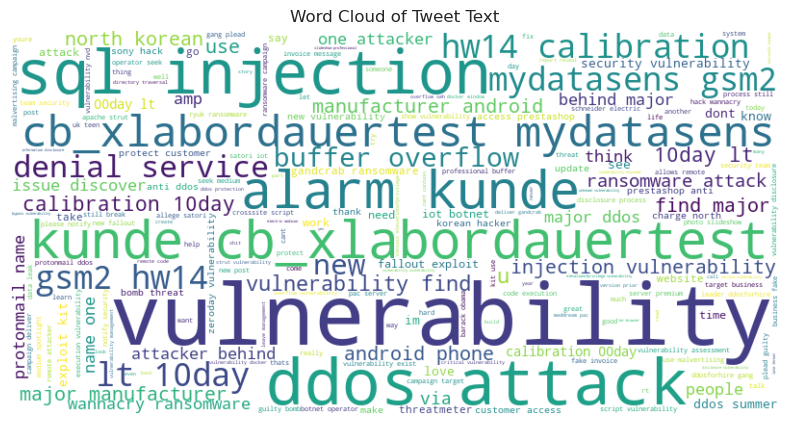

In [16]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

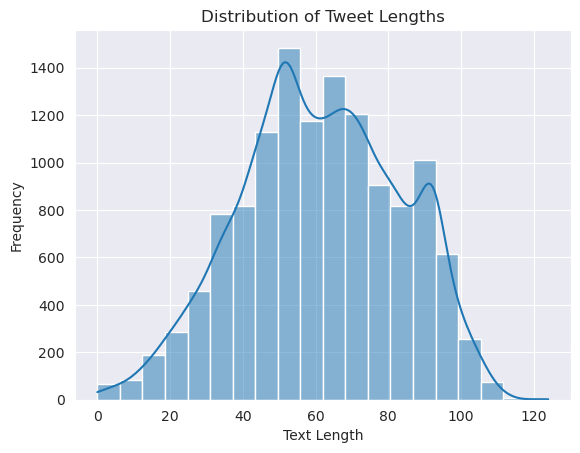

In [17]:
tweets['text_length'] = tweets['text'].apply(func=len)
sns.histplot(
    data=tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [18]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 11890), ('computer security', 7501), ('antivirus and malware', 4755), ('software', 3949), ('network security', 3503), ('hardware', 2538), ('society', 2059), ('computer', 1800), ('business and industrial', 1798), ('databases', 1565)]


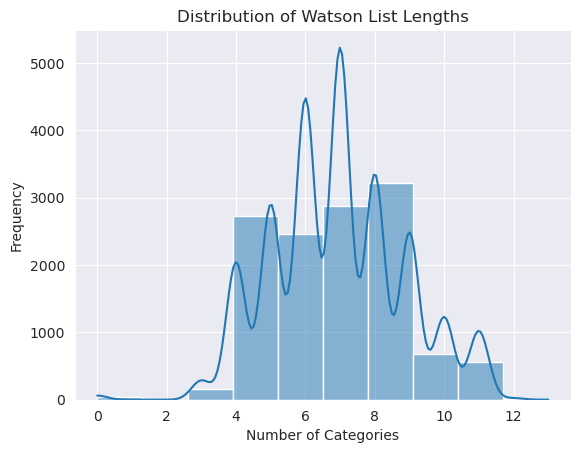

In [19]:
# Category Depth Analysis
tweets['watson_list_length'] = tweets['watson_list'].apply(func=len)

sns.histplot(
    data=tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [20]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 7501), (('technology and computing', 'antivirus and malware'), 4755), (('computer security', 'antivirus and malware'), 4755), (('technology and computing', 'software'), 3949), (('technology and computing', 'network security'), 3503), (('computer security', 'network security'), 3503), (('technology and computing', 'hardware'), 2538), (('technology and computing', 'computer'), 1800), (('hardware', 'computer'), 1800), (('technology and computing', 'databases'), 1565)]


In [21]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 11890), ('computer', 10680), ('antivirus', 4755), ('software', 3952), ('network', 3606), ('hardware', 2538), ('society', 2059), ('business', 2012), ('databases', 1565), ('crime', 1506), ('art', 1415), ('law,', 1413), ('consumer', 1243), ('science', 1224), ('operating', 1119), ('health', 1100), ('home', 914), ('personal', 890), ('programming', 860), ('property', 779), ('internet', 615), ('movies', 605), ('hobbies', 575), ('government', 563), ('networking', 552), ('javascript', 493), ('linux', 482), ('vpn', 469), ('finance', 453), ('tv', 441), ('disorders', 423), ('sports', 416), ('telephones', 412), ('legal', 408), ('physics', 408), ('mobile', 406), ('assault', 394), ('travel', 389), ('food', 385), ('optics', 378), ('disease', 374), ('music', 373), ('smart', 372), ('burglary', 371), ('router', 337), ('law', 310), ('windows', 306), ('company', 305), ('mental', 301), ('weather', 291), ('social', 285), ('meteorological', 273), ('kidnapping', 

### 4.4. Target Analysis

Target Frequencies:
computer security: 7501
software: 4294
hardware: 2609
other: 1804
networking: 1130
operating systems: 1119


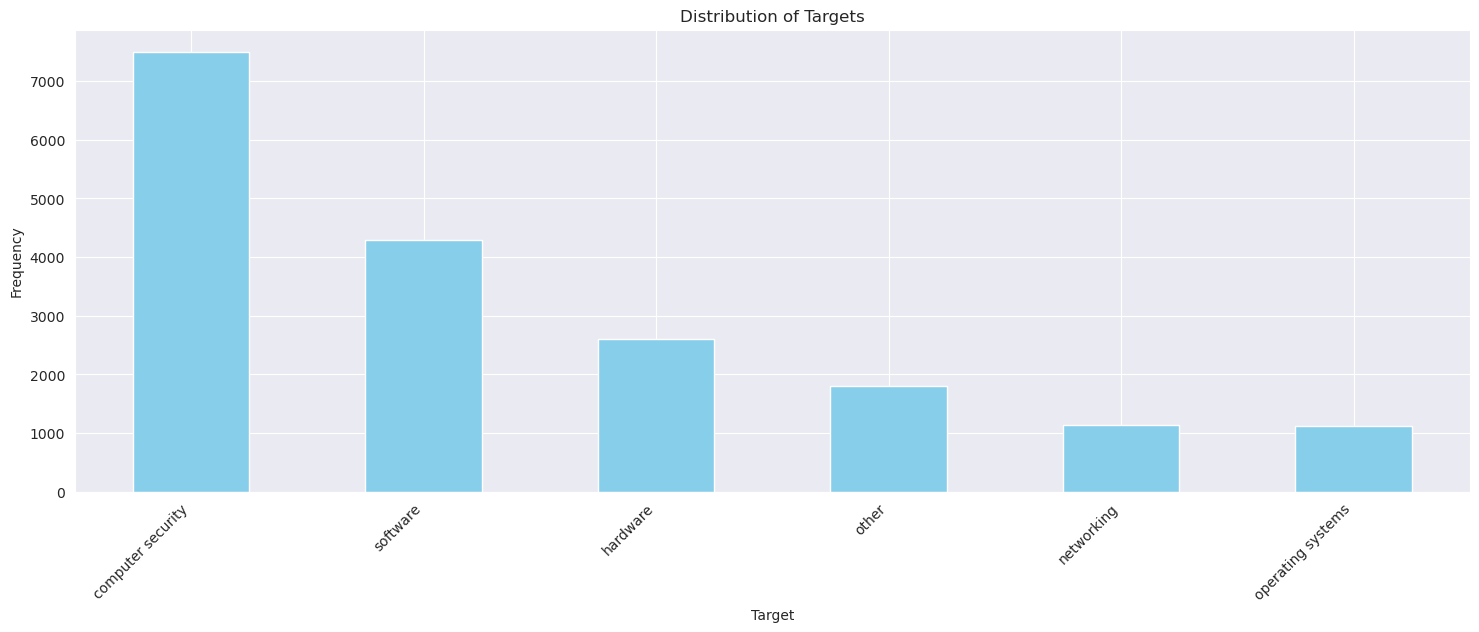

In [22]:
class_freq = Counter([item for sublist in tweets['target'] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 4125
('other',): 1804
('software', 'computer security'): 1527
('software',): 937
('hardware',): 714
('hardware', 'computer security'): 646
('software', 'hardware'): 391
('software', 'operating systems'): 349
('software', 'computer security', 'hardware'): 323
('networking',): 306
('software', 'computer security', 'networking'): 213
('computer security', 'networking'): 189
('software', 'operating systems', 'computer security'): 178
('software', 'networking'): 163
('operating systems',): 161
('operating systems', 'computer security'): 135
('software', 'operating systems', 'hardware'): 99
('hardware', 'operating systems'): 96
('hardware', 'networking'): 92
('hardware', 'computer security', 'networking'): 72
('hardware', 'operating systems', 'computer security'): 69
('software', 'hardware', 'networking'): 63
('hardware', 'software'): 39
('operating systems', 'computer security', 'networking'): 19
('software', 'operating systems', 'networking'): 7


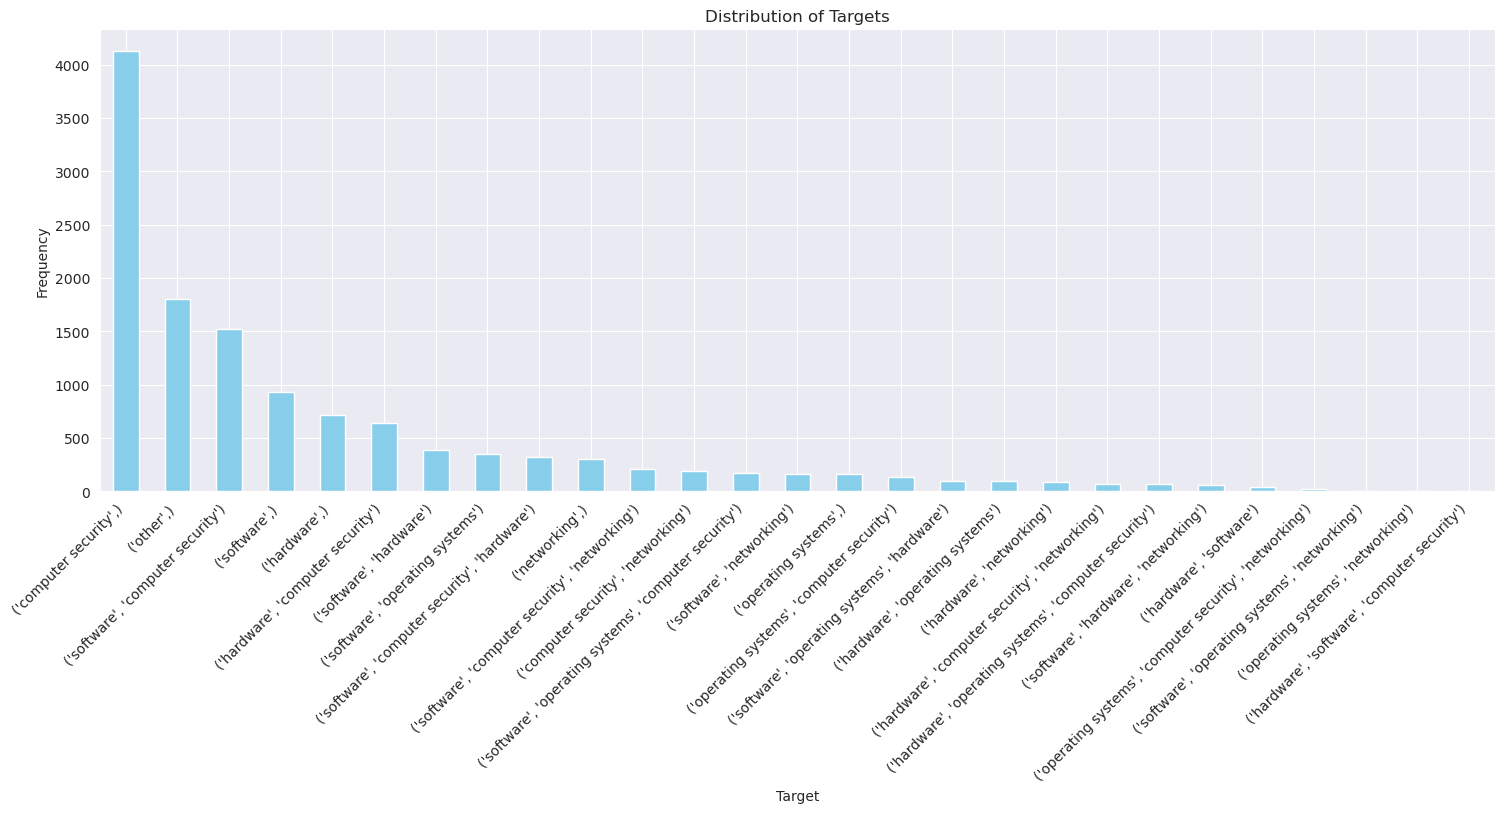

In [23]:
target_freq = Counter(tuple(item) for item in tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [24]:
# Multi-Label Analysis
multi_label_counts = tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 4681


In [25]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(tweets['target'], tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer security':
vulnerability    3456
ddos             1245
attack            946
ransomware        691
security          644
injection         467
sql               441
new               423
botnet            390
exploit           378
dtype: int64
Top 10 words for target 'other':
10day                 599
ransomware            400
lt                    371
alarm                 369
calibration           369
cb_xlabordauertest    369
gsm2                  369
hw14                  369
kunde                 369
mydatasens            369
dtype: int64
Top 10 words for target 'software':
vulnerability    1877
injection         519
sql               483
security          378
buffer            274
attack            270
overflow          267
exploit           235
new               221
ddos              209
dtype: int64
Top 10 words for target 'operating systems':
vulnerability    479
overflow         206
buffer           203
window           176
service          1

## 5. Feature Engineering

In [26]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = tweets[tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer security',): 4125
('other',): 1804
('software', 'computer security'): 1527
('software',): 937
('hardware',): 714
('hardware', 'computer security'): 646
('software', 'hardware'): 391
('software', 'operating systems'): 349
('software', 'computer security', 'hardware'): 323
('networking',): 306
('software', 'computer security', 'networking'): 213
('computer security', 'networking'): 189
('software', 'operating systems', 'computer security'): 178
('software', 'networking'): 163
('operating systems',): 161
('operating systems', 'computer security'): 135
('software', 'operating systems', 'hardware'): 99
('hardware', 'operating systems'): 96
('hardware', 'networking'): 92
('hardware', 'computer security', 'networking'): 72
('hardware', 'operating systems', 'computer security'): 69
('software', 'hardware', 'networking'): 63
('hardware', 'software'): 39
('operating systems', 'computer security', 'networking'): 19
('software', 'operating systems', 'networki

Preprocess the `text` column into embeddings

In [27]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path,
            preprocessing_list=[replace_text_components, clean_text]
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str


texts = filtered_df['text']
x = preprocess_texts(
    list_str=texts,
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None
)
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)

Convert the `target` column into a binary multi-label matrix

In [28]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Create a dictionary that maps label indices to unique label sets

In [31]:
targets_list_mcp, y_mcp = np.unique(ar=y, axis=0, return_inverse=True)
targets_dict_mcp = {i: tuple(lbl_set) for i, lbl_set in enumerate(targets_list_mcp)}

Perform pruning and subsampling of the dataset to remove infrequent targets

In [32]:
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=x,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

## 6. Model Training

In [40]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_mcp, y_val_mcp = train_test_split(
    x, y, y_mcp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_mcp
)

print(
    f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 10182 × 768    	y = 10182 × 6      
Validation:    	X = 2546 × 768     	y = 2546 × 6       


In [41]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 11142 × 768    	y = 11142          
Validation:    	X = 2786 × 768     	y = 2786           


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y_mcp = smote.fit_resample(x, y_mcp)
y = np.array(targets_list_mcp[y_mcp])
print(f"{X.shape}, {len(y_mcp)}")

In [35]:
models = {}

### 6.1. Binary Problems

#### 6.1.1. BR (Binary Relevance)

In [36]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        models[f"BR[{k}]"] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 3/3 [03:24<00:00, 68.11s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [37]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        models[f"CLR[{k}]"] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 3/3 [09:41<00:00, 193.83s/it]


#### 4.1.3. CC (Classifier Chains)


In [38]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        models[f"CC[{k}]"] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [05:06<00:00, 102.18s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [42]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=targets_dict_mcp,
            random_state=RANDOM_STATE
        )

        models[f"LP[{k}]"] = model.fit(
            x=X_train,
            y=y_train_mcp
        )

100%|██████████| 3/3 [04:22<00:00, 87.48s/it] 


#### 4.2.2. PSt (Pruned Sets)


In [43]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        models[f"PSt[{k}]"] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 3/3 [03:31<00:00, 70.43s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [46]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        models[f"CDN[{k}]"] = model.fit(
            x=X_train,
            y=y_train
        )

  0%|          | 0/3 [00:00<?, ?it/s]

#### 4.3.2. MBR (Meta-Binary Relevance)


In [47]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        models[f"MBR[{k}]"] = model.fit(
            x=X_train,
            y=y_train
        )

  0%|          | 0/3 [00:00<?, ?it/s]

## 7. Model Evaluation

In [69]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [70]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique={k: v for k, v in models.items() if 'BR' in k and 'MBR' not in k},
    classes=mlb.classes_
)

In [71]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.85      0.89      0.87      1501
         hardware       0.88      0.61      0.72       522
       networking       0.97      0.49      0.65       226
operating systems       0.95      0.67      0.78       224
            other       0.86      0.53      0.66       361
         software       0.85      0.74      0.79       860

        micro avg       0.86      0.74      0.80      3694
        macro avg       0.89      0.65      0.75      3694
     weighted avg       0.87      0.74      0.79      3694
      samples avg       0.76      0.74      0.74      3694

Accuracy:	0.6304
AUC:	0.8000


#### 7.1.2. CLR (Calibrated Label Ranking)


In [72]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique={k: v for k, v in models.items() if 'CLR' in k},
    classes=mlb.classes_
)

In [73]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.87      0.89      0.88      1501
         hardware       0.80      0.64      0.71       522
       networking       0.87      0.52      0.65       226
operating systems       0.83      0.71      0.77       224
            other       0.76      0.59      0.67       361
         software       0.83      0.76      0.79       860

        micro avg       0.84      0.76      0.80      3694
        macro avg       0.83      0.69      0.74      3694
     weighted avg       0.84      0.76      0.79      3694
      samples avg       0.76      0.76      0.75      3694

Accuracy:	0.6269
AUC:	0.8121


#### 7.1.3. CC (Classifier Chains)


In [74]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique={k: v for k, v in models.items() if 'CC' in k},
    classes=mlb.classes_
)

In [75]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.82      0.91      0.86      1501
         hardware       0.79      0.66      0.72       522
       networking       0.77      0.56      0.65       226
operating systems       0.82      0.72      0.77       224
            other       0.76      0.59      0.67       361
         software       0.80      0.77      0.78       860

        micro avg       0.81      0.78      0.79      3694
        macro avg       0.79      0.70      0.74      3694
     weighted avg       0.80      0.78      0.79      3694
      samples avg       0.79      0.77      0.77      3694

Accuracy:	0.6461
AUC:	0.8101


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [76]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(targets_dict_mcp[yp]) for yp in y_val_mcp]),
    technique={k: v for k, v in models.items() if 'LP' in k},
    classes=mlb.classes_
)

In [77]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.81      0.93      0.87      1501
         hardware       0.87      0.60      0.71       522
       networking       0.94      0.48      0.64       226
operating systems       0.90      0.66      0.76       224
            other       0.67      0.65      0.66       361
         software       0.86      0.73      0.79       860

        micro avg       0.82      0.77      0.79      3694
        macro avg       0.84      0.67      0.74      3694
     weighted avg       0.83      0.77      0.79      3694
      samples avg       0.80      0.77      0.77      3694

Accuracy:	0.6665
AUC:	0.7994


#### 7.2.2. PSt (Pruned Sets)


In [78]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique={k: v for k, v in models.items() if 'PSt' in k},
    classes=mlb.classes_
)

In [79]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                   precision    recall  f1-score   support

computer security       0.79      0.91      0.84      1587
         hardware       0.90      0.57      0.69       522
       networking       0.64      0.48      0.55       322
operating systems       0.73      0.51      0.60       320
            other       0.69      0.68      0.69       361
         software       0.86      0.68      0.76       893

        micro avg       0.79      0.73      0.76      4005
        macro avg       0.77      0.64      0.69      4005
     weighted avg       0.79      0.73      0.75      4005
      samples avg       0.76      0.73      0.73      4005

Accuracy:	0.6224
AUC:	0.7776


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [80]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique={k: v for k, v in models.items() if 'CDN' in k},
    classes=mlb.classes_
)

In [81]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.79      0.79      0.79      1501
         hardware       0.72      0.58      0.64       522
       networking       0.83      0.48      0.61       226
operating systems       0.91      0.66      0.76       224
            other       0.37      0.49      0.42       361
         software       0.77      0.72      0.74       860

        micro avg       0.72      0.69      0.71      3694
        macro avg       0.73      0.62      0.66      3694
     weighted avg       0.74      0.69      0.71      3694
      samples avg       0.68      0.67      0.66      3694

Accuracy:	0.5522
AUC:	0.7578


#### 7.3.2. MBR (Meta-Binary Relevance)


In [82]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique={k: v for k, v in models.items() if 'MBR' in k},
    classes=mlb.classes_
)

In [83]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.87      0.89      0.88      1501
         hardware       0.89      0.62      0.73       522
       networking       0.93      0.53      0.67       226
operating systems       0.91      0.68      0.78       224
            other       0.82      0.57      0.67       361
         software       0.86      0.72      0.79       860

        micro avg       0.87      0.75      0.80      3694
        macro avg       0.88      0.67      0.75      3694
     weighted avg       0.87      0.75      0.80      3694
      samples avg       0.76      0.74      0.74      3694

Accuracy:	0.6363
AUC:	0.8088


## 8. Summary


In [84]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.630401,BR[xgb],OneVsRestClassifier(estimator=XGBClassifier(ba...,0.762831,0.735598,0.736777,0.090469,0.864439,0.742285,0.798718,0.893218,0.654729,0.745629,2.93205,precision recall f1-sco...
CLR,0.626866,CLR[xgb],CalibratedLabelRankClassifier(classes=array(['...,0.764696,0.757528,0.746736,0.09276,0.840359,0.760964,0.798693,0.827042,0.685043,0.744362,2.835428,precision recall f1-sco...
CC,0.646112,CC[xgb],ChainOfClassifiers(classes=array(['computer se...,0.789605,0.773305,0.767636,0.099044,0.805548,0.778289,0.791684,0.794275,0.701832,0.741503,2.783975,precision recall f1-sco...
LP,0.666536,LP[xgb],LabelPowersetClassifier(classifier=XGBClassifi...,0.803286,0.769442,0.773082,0.096753,0.821906,0.765836,0.792881,0.84171,0.67488,0.737053,2.767086,precision recall f1-sco...
PST,0.622398,PSt[xgb],LabelPowersetClassifier(classifier=XGBClassifi...,0.764417,0.728404,0.733106,0.111809,0.788493,0.728839,0.757493,0.768279,0.638679,0.689341,2.968413,precision recall f1-sco...
CDN,0.567164,CDN[xgb],ConditionalDependencyNetwork(classifier=XGBCla...,0.69894,0.680348,0.67663,0.134394,0.733961,0.696806,0.714901,0.729804,0.61826,0.661187,3.19835,precision recall f1-sco...
MBR,0.636292,MBR[xgb],MetaBinaryRelevance(classifier=XGBClassifier(b...,0.76306,0.739853,0.739444,0.088636,0.869551,0.745263,0.802624,0.878327,0.667995,0.752577,2.89945,precision recall f1-sco...


In [97]:
max_score = np.inf
optimal_model = None
for _, performance in performances.iterrows():
    if max_score > performance['Hamming loss']:
        max_score = performance['Hamming loss']
        optimal_model = performance['Model']

optimal_model
#if OVERWRITE:
#    joblib.dump(optimal_model, GENERAL_PKL, compress=9)

MetaBinaryRelevance(classifier=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=42, ...),
                    use_cross_val=True)

In [92]:
optimal_model.predict(preprocess_texts(pd.Series(['I am excited for the match AS Roma vs Lazio']),
                                       model_path='sentence-transformers/all-mpnet-base-v2', embedding_dim=None))

array([[0, 0, 0, 0, 1, 0]])

In [93]:
z = joblib.load(filename=GENERAL_PKL)
z.predict(preprocess_texts(pd.Series(['I am excited for the match AS Roma vs Lazio']),
                           model_path='sentence-transformers/all-mpnet-base-v2', embedding_dim=None))

array([[0, 0, 0, 0, 1, 0]])